## Authenticate and Initialize Earth Engine

In [2]:
!pip install earthengine-api

In [3]:
pip install geemap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import urllib.request
url = "https://raw.githubusercontent.com/nitinmagima/endofseasonmonitoring_madagascar/refs/heads/main/utils.py"
urllib.request.urlretrieve(url, "utils.py")

('utils.py', <http.client.HTTPMessage at 0x1e458b54a10>)

import ee
import geemap
import utils as u
from IPython.display import HTML, Markdown, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ee.Authenticate()
ee.Initialize(project="ee-mp4409")

## Initialize Map

In [7]:
import ee
import geemap
import utils as u
from IPython.display import HTML, Markdown, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [8]:
m = geemap.Map(basemap='Esri.WorldTopoMap')
m.setCenter(-10, 20, 5)
m

Map(center=[20, -10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [9]:
country_name = 'Mauritania'
admin_level = 'level0'

In [10]:
roi = m.user_roi

if roi is None:
    roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
    roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))
    styleParams = {
        'fillColor': 'b5ffb4',
        'color': '00909F',
        'width': 1.0,
    }
    styleRoi = roi.style(**styleParams)
    m.addLayer(styleRoi, {}, country_name)
print('ROI type:', roi.getInfo()['type'])


ROI type: FeatureCollection


In [11]:
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1')
evi_band = 'EVI'
ndvi_band = 'NDVI'
selected_bands = viirs.select([evi_band, ndvi_band])
selected_bands = selected_bands.filterBounds(roi)

C:\NewDownload\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for NOAA/VIIRS/001/VNP13A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_001_VNP13A1

  warnings.warn(warning, category=DeprecationWarning)


In [12]:
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
spimonthlyvis = {"opacity":1,"bands":["SPI"],"min":-4,"max":4,"palette":["d53e4f","fc8d59","fee08b","ffffbf","e6f598","99d594","3288bd"]}
spi16dayvis = {"opacity":1,"bands":["SPI_16Days"],"min":-4,"max":4,"palette":["d53e4f","fc8d59","fee08b","ffffbf","e6f598","99d594","3288bd"]}

### Set Time Frame

In [14]:
firstimage = ee.Date(ee.List(chirps.get('date_range')).get(0))
latestimage = ee.Date(chirps.limit(1, 'system:time_start',  False).first().get('system:time_start'))

### Set Resolution

In [16]:
resolution = 5550

### Set Time Scale Information For SPI
##### Assess the precipitation anomaly over a specific period. The time scale determines how many months' worth of precipitation you want to include in the calculation of the SPI.

In [18]:
timestep = '1'

### Set Time Shift For VIIRS Related SPI
##### - For example, a shift = -5 would mean that the SPI for a given period is calculated 5 days before the VIIRS data start date and finishes 5 days earlier than the VIIRS data end date.
##### - The days = '16' represents the 16-day period over which the SPI is calculated. This is aligned with the frequency of the VIIRS data (which is also provided on a 16-day interval). This gives you the exact window for which the SPI is calculated.

In [20]:
shift = '0'
days = '16'

### SPI Calculations

In [22]:
thresholdsmonths = ee.Number(12)

In [23]:
timedif = (latestimage.difference(firstimage, 'month')).divide(ee.Number.parse(timestep))

In [24]:
list = ee.List.sequence(0, timedif)

In [25]:
def func_gou(month):
    zero = ee.Number(0)
    delta = (zero.subtract(month)).multiply(ee.Number.parse(timestep))
    # amount：表示你希望推进的数量，可以是一个正数或负数。正数表示将日期推进，负数表示将日期向回推。
    latestdate = latestimage.advance(1, 'day')
    return latestdate.advance(delta, 'month')

timelistdate = list.map(func_gou)

In [26]:
sortedtimelist = timelistdate.sort()

In [27]:
def func_fxo(monthly_sum):
    timestep_num = ee.Number.parse(timestep)
    starttime = ee.Date(monthly_sum).advance(timestep_num.multiply(-1), 'month')
    endtime = ee.Date(monthly_sum)
    filteredCHIRPS = chirps.filterDate(starttime, endtime)
    clippedCHIRPS = filteredCHIRPS.map(lambda clip:clip.clip(roi))
    imageAmount = clippedCHIRPS.size()
    summedCollection = clippedCHIRPS.sum().set({
        'Used_Images': imageAmount,
        'Start_Date': ee.Date(filteredCHIRPS.first().get('system:time_start')),
        'End_Date': ee.Date(filteredCHIRPS.sort('system:time_end', False).first().get('system:time_end')),
        'system:time_start': filteredCHIRPS.first().get('system:time_start'),
        'system:time_end': filteredCHIRPS.sort('system:time_end', False).first().get('system:time_end')
    })
    time = ee.Date(summedCollection.get('system:time_end')).difference(ee.Date(summedCollection.get('system:time_start')), 'month').round()
    
    summedImage = summedCollection.set({
        'Observed_Months': time
    })
    
    return ee.Image(ee.Algorithms.If(time.gte(timestep_num), summedImage))

precipitationsum = ee.ImageCollection.fromImages(ee.List(timelistdate).map(func_fxo))

In [28]:
summedchirpscollection = precipitationsum.map(lambda img: img.copyProperties(chirps))

In [29]:
first_image = summedchirpscollection.first().getInfo()
print(first_image)

{'type': 'Image', 'bands': [{'id': 'precipitation', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'date_range': [347155200000, 1646006400000], 'period_mapping': [347155200000, 1646006400000], 'type_name': 'ImageCollection', 'period': 1, 'keywords': ['chg', 'climate', 'geophysical', 'precipitation', 'ucsb', 'weather'], 'thumb': 'https://mw1.google.com/ges/dd/images/CHIRPS_thumb.png', 'description': '<p>Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)\nis a 30+ year quasi-global rainfall dataset. CHIRPS incorporates\n0.05° resolution satellite imagery with in-situ station data\nto create gridded rainfall time series for trend analysis and seasonal\ndrought monitoring.</p><p><b>Provider: <a href="https://chc.ucsb.edu/data/chirps">UCSB/CHG</a></b><br><p><b>Resolution</b><br>5566 meters\n</p><p><b>Cadence</b><br>\n  1 day\n</p><p><b>Bands</b><table class="eecat"><tr><th scope="col">

In [30]:
# SPI = P(accumulated precipitation within a period)-μ(longterm average)/σ(sd of this period), negative means below average, vise versa

thresholdmonths = ee.Number(12)  
def to_spi(to_spi_img):
    band_for_spi = to_spi_img.select(['precipitation'], ['SPI']) # select pre and rename as SPI
    calc = to_spi_img.expression(
        '(precipitation - mean) / stdDev',
        {
            'precipitation': band_for_spi,
            'mean': to_spi_img.select('precipitation_mean'),
            'stdDev': to_spi_img.select('precipitation_stdDev')
        }
    )
    return to_spi_img.addBands(calc)

# If the SPI should be calculated for less than 12 months, the DOY information have to be used to find the correct images.

def spi_smaller_12():
    # Calculate Statistics
    def to_stats(to_stats_img):
        start_doy = ee.Date(to_stats_img.get('system:time_start')).getRelative('day', 'year')
        end_doy = ee.Date(to_stats_img.get('system:time_end')).getRelative('day', 'year')
        collection_for_stats = summedchirpscollection \
            .filter(ee.Filter.calendarRange(start_doy, end_doy, 'day_of_year')) \
            .reduce(ee.Reducer.stdDev().combine(ee.Reducer.mean(), None, True))
        return to_stats_img.addBands(collection_for_stats)
    
    stats = summedchirpscollection.map(to_stats)
    
    spi_1_11 = stats.map(to_spi)
    return spi_1_11

# If the SPI should be calculated for 12 or more months, the DOY information are not necessary.
# However, from 12 months onwards, it is just possible to calculate the SPI for whole years.
# Eg. for 24 or 48 months. Calculating an SPI-18 will not work within this script

def spi_greater_equal_12():
    # Calculate Statistics
    def to_stats(to_stats_img):
        collection_for_stats = summedchirpscollection \
            .reduce(ee.Reducer.stdDev().combine(ee.Reducer.mean(), None, True))
        return to_stats_img.addBands(collection_for_stats)
    
    stats = summedchirpscollection.map(to_stats)
    
    spi_12_n = stats.map(to_spi)
    return spi_12_n

# Decide which approach to use based on the timestep
spi = ee.ImageCollection(
    ee.Algorithms.If(
        ee.Number.parse(timestep).gte(thresholdmonths), # To see if timestep is larger than threshold. I set the step is 1 while threshold is 12
        spi_greater_equal_12(),
        spi_smaller_12()
    )
)

In [31]:
spi.first()

In [32]:
m = geemap.Map(basemap='Esri.WorldTopoMap')
palette = ['blue', 'aqua', 'lime', 'yellow', 'orange', 'red']
viz_params = {
    'min':-2,
    'max':2,
    'palette': palette
}
first_spi_image = ee.Image(spi.first().select('SPI'))
m = geemap.Map(center=[20, -10], zoom=6)
m.addLayer(first_spi_image, viz_params, 'SPI Analysis Outcome')
m

Map(center=[20, -10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [33]:
# Get the first SPI image
first_spi_image = ee.Image(spi.first())

# Get the start date（ms）
start_time = first_spi_image.get('system:time_start')
end_time = first_spi_image.get('system:time_end')

# Change to a readable date format
start_date = ee.Date(start_time).format('YYYY-MM-dd').getInfo()
end_date = ee.Date(end_time).format('YYYY-MM-dd').getInfo()

# Print the time slot
print(f"First SPI Image Time Range: {start_date} to {end_date}")


First SPI Image Time Range: 2025-01-01 to 2025-02-01


### Data Analysis (Precipitation & Temperature)

Enter the year for Climate Data Analysis: 2016


Sowing - Precipitation: 0.28464817068791975 mm
Sowing - Temperature: 32.71 °C
Growing - Precipitation: 0.6560445619554202 mm
Growing - Temperature: 32.33 °C
Harvesting1 - Precipitation: 0.06178998877771131 mm
Harvesting1 - Temperature: 22.46 °C
Harvesting2 - Precipitation: 0.03850769771320466 mm
Harvesting2 - Temperature: 16.96 °C


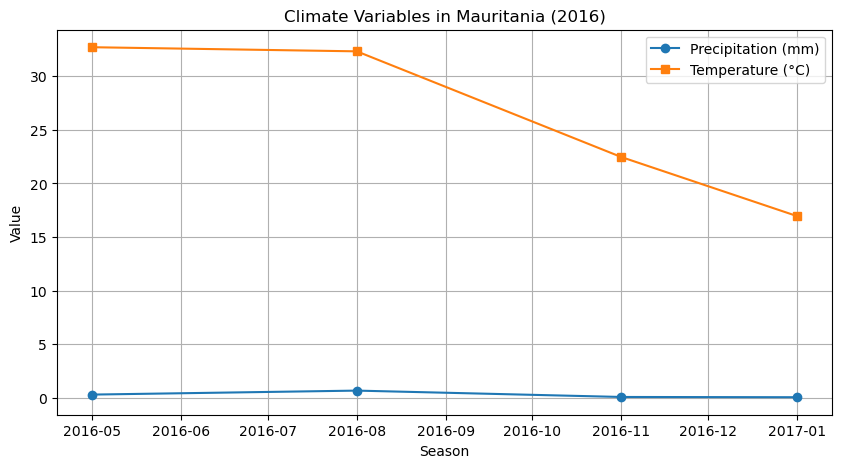

In [104]:
ee.Initialize()
mauritania = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Mauritania'))

# Select Variables
precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation")
temperature = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select("temperature_2m")

# Define Growing Period
seasons = {
    "Sowing": {"start": "05-01", "end": "07-31"},
    "Growing": {"start": "08-01", "end": "10-31"},
    "Harvesting1": {"start": "11-01", "end": "12-31"},
    "Harvesting2": {"start": "01-01", "end": "01-31"} 
}

year = int(input("Enter the year for Climate Data Analysis:"))

def get_seasonal_data(var, season, y):
    start_date = f"{year}-{seasons[season]['start']}"
    end_date = f"{year}-{seasons[season]['end']}"

    if "Harvesting2" in season:
        start_date = f"{y+1}-{seasons[season]['start']}"
        end_date = f"{y+1}-{seasons[season]['end']}"
    
    filtered_data = var.filterDate(start_date, end_date).mean().clip(mauritania)
    return filtered_data

seasonal_data = {}
for season in seasons:
    seasonal_data[season] = {
        "precipitation": get_seasonal_data(precipitation, season, year),
        "temperature": get_seasonal_data(temperature, season, year)
    }

# Visualization
dates = [datetime.datetime(year, 5, 1), 
         datetime.datetime(year, 8, 1), 
         datetime.datetime(year, 11, 1),
         datetime.datetime(year+1, 1, 1)
        ]

precip_values = []
temp_values = []

for season in seasons:
    precip_result = seasonal_data[season]["precipitation"].reduceRegion(
        reducer=ee.Reducer.mean(), geometry=mauritania, scale=1000
    ).getInfo()
    
    temp_result = seasonal_data[season]["temperature"].reduceRegion(
        reducer=ee.Reducer.mean(), geometry=mauritania, scale=1000
    ).getInfo()

    # 处理 None 值，防止 KeyError
    precip_value = precip_result.get('precipitation', 0) if precip_result else 0
    temp_value_K = temp_result.get('temperature_2m', 0) if temp_result else 0
    temp_value_C = temp_value_K - 273.15  

    print(f"{season} - Precipitation: {precip_value} mm")
    print(f"{season} - Temperature: {temp_value_C:.2f} °C")

    precip_values.append(precip_value)
    temp_values.append(temp_value_C)


plt.figure(figsize=(10, 5))
plt.plot(dates, precip_values, marker='o', label="Precipitation (mm)")
plt.plot(dates, temp_values, marker='s', label="Temperature (°C)")
plt.xlabel("Season")
plt.ylabel("Value")
plt.legend()
plt.title(f"Climate Variables in Mauritania ({year})")
plt.grid()
plt.show()

### Data Analysis (Agriculture Variables)

Enter the year for Climate Data Analysis: 2016


Checking Date Range: 2016-05-01 to 2016-07-31
Checking Date Range: 2016-05-01 to 2016-07-31
Checking Date Range: 2016-05-01 to 2016-07-31
Checking Date Range: 2016-08-01 to 2016-10-31
Checking Date Range: 2016-08-01 to 2016-10-31
Checking Date Range: 2016-08-01 to 2016-10-31
Checking Date Range: 2016-11-01 to 2016-12-31
Checking Date Range: 2016-11-01 to 2016-12-31
Checking Date Range: 2016-11-01 to 2016-12-31
Checking Date Range: 2017-01-01 to 2017-01-31
Checking Date Range: 2017-01-01 to 2017-01-31
Checking Date Range: 2017-01-01 to 2017-01-31
Sowing (2016) - Soil Moisture: 3.223
Sowing (2016) - NDVI: 1100.123
Sowing (2016) - EVI: 834.781
Growing (2016) - Soil Moisture: 4.159
Growing (2016) - NDVI: 1352.806
Growing (2016) - EVI: 1001.404
Harvesting1 (2016) - Soil Moisture: 2.740
Harvesting1 (2016) - NDVI: 1140.941
Harvesting1 (2016) - EVI: 844.082
Harvesting2 (2016) - Soil Moisture: 2.805
Harvesting2 (2016) - NDVI: 1132.635
Harvesting2 (2016) - EVI: 845.066


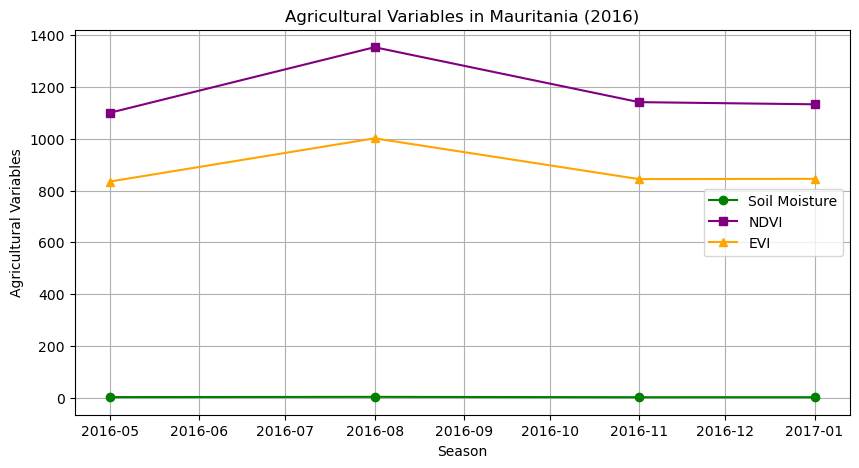

In [102]:
mauritania = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Mauritania'))
soil_moisture = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture").select("ssm")  # Soil Surface Moisture
vegetation = ee.ImageCollection("MODIS/006/MOD13A2").select(["NDVI", "EVI"])  # NDVI & EVI

seasons = {
    "Sowing": {"start": "05-01", "end": "07-31"},
    "Growing": {"start": "08-01", "end": "10-31"},
    "Harvesting1": {"start": "11-01", "end": "12-31"},
    "Harvesting2": {"start": "01-01", "end": "01-31"} 
}

year = int(input("Enter the year for Climate Data Analysis:"))

def get_agricultural_data(var, season, y):
    if "Harvesting2" in season:
        start_date = f"{y+1}-{seasons[season]['start']}" 
        end_date = f"{y+1}-{seasons[season]['end']}"
    else:
        start_date = f"{y}-{seasons[season]['start']}"
        end_date = f"{y}-{seasons[season]['end']}"
    
    print(f"Checking Date Range: {start_date} to {end_date}")  
    return var.filterDate(start_date, end_date).mean().clip(mauritania)

agricultural_data = {}
for season in seasons:
    agricultural_data[season] = {
        "soil_moisture": get_agricultural_data(soil_moisture, season, year),
        "NDVI": get_agricultural_data(vegetation.select("NDVI"), season, year),
        "EVI": get_agricultural_data(vegetation.select("EVI"), season, year)
    }

dates = [
    datetime.datetime(year, 5, 1),
    datetime.datetime(year, 8, 1),
    datetime.datetime(year, 11, 1),
    datetime.datetime(year + 1, 1, 1)
]

sm_values, ndvi_values, evi_values = [], [], []

for season in seasons:
    sm_result = agricultural_data[season]["soil_moisture"].reduceRegion(
        reducer=ee.Reducer.mean(), geometry=mauritania, scale=10000
    ).getInfo()

    ndvi_result = agricultural_data[season]["NDVI"].reduceRegion(
        reducer=ee.Reducer.mean(), geometry=mauritania, scale=10000
    ).getInfo()

    evi_result = agricultural_data[season]["EVI"].reduceRegion(
        reducer=ee.Reducer.mean(), geometry=mauritania, scale=10000
    ).getInfo()

    sm_value = sm_result.get('ssm', 0) if sm_result else 0
    ndvi_value = ndvi_result.get('NDVI', 0) if ndvi_result else 0
    evi_value = evi_result.get('EVI', 0) if evi_result else 0

    print(f"{season} ({year}) - Soil Moisture: {sm_value:.3f}")
    print(f"{season} ({year}) - NDVI: {ndvi_value:.3f}")
    print(f"{season} ({year}) - EVI: {evi_value:.3f}")

    sm_values.append(sm_value)
    ndvi_values.append(ndvi_value)
    evi_values.append(evi_value)

plt.figure(figsize=(10, 5))

plt.plot(dates, sm_values, marker='o', label="Soil Moisture", color='g')
plt.plot(dates, ndvi_values, marker='s', label="NDVI", color='purple')
plt.plot(dates, evi_values, marker='^', label="EVI", color='orange')

plt.xlabel("Season")
plt.ylabel("Agricultural Variables")
plt.legend()
plt.title(f"Agricultural Variables in Mauritania ({year})")
plt.grid()

plt.show()